In [27]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import ConcatDataset, Subset

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv4 = nn.Conv2d(256, 256, 3, 1, 1)
        self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
        self.conv6 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv7 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv8 = nn.Conv2d(512, 512, 3, 1, 1)

        self.norm1 = nn.BatchNorm2d(64)
        self.norm2 = nn.BatchNorm2d(128)
        self.norm3 = nn.BatchNorm2d(256)
        self.norm4 = nn.BatchNorm2d(256)
        self.norm5 = nn.BatchNorm2d(512)
        self.norm6 = nn.BatchNorm2d(512)
        self.norm7 = nn.BatchNorm2d(512)
        self.norm8 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, input):
        dropout = nn.Dropout(0.5)
        c1 = F.relu(self.norm1(self.conv1(input)))
        s2 = F.max_pool2d(c1, (2, 2))
        c3 = F.relu(self.norm2(self.conv2(s2)))
        s3 = F.max_pool2d(c3, (2, 2))
        c4 = F.relu(self.norm3(self.conv3(s3)))
        c5 = F.relu(self.norm4(self.conv4(c4)))
        s5 = F.max_pool2d(c5, (2, 2))
        c6 = F.relu(self.norm5(self.conv5(s5)))
        c7 = F.relu(self.norm6(self.conv6(c6)))
        s7 = F.max_pool2d(c7, (2, 2))
        c8 = F.relu(self.norm7(self.conv7(s7)))
        c9 = F.relu(self.norm8(self.conv8(c8)))
        s9 = F.max_pool2d(c9, (2, 2))
        s9 = torch.flatten(s9, 1)
        f10 = F.relu(self.fc1(s9))
        d11 = dropout(f10)
        f12 = F.relu(self.fc2(d11))
        d13 = dropout(f12)
        output = self.fc3(d13)
        return output

In [9]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Load MNIST Dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# DataLoader for batching
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

print(f"Train Dataset Size: {len(train_dataset)}, Test Dataset Size: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.23MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]

Train Dataset Size: 60000, Test Dataset Size: 10000


In [13]:
def train_model(net, train_loader, test_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    num_epochs = 5
    device =  torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        net.to(device)
        net.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # Optimization steps
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # Training accuracies and losses
        train_loss = 0
        correct_train = 0
        total_train = 0
        net.eval()
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                # Compute training loss
                loss = criterion(outputs, labels)
                train_loss += loss.item()
                # Compute training accuracy
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
        
        # Compute average training loss and accuracy
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Test accuracies and losses
        correct_test = 0
        total_test = 0
        test_loss = 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                # Compute test loss
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                # Compute test accuracy
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
    
        # Compute average test loss and accuracy
        test_loss /= len(test_loader)
        test_acc = 100 * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print("Training complete.")
    return train_losses, train_accuracies, test_losses, test_accuracies

def evaluate_model(model, test):
    model.eval()
    correct = 0
    total = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for images, labels in test:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [15]:
net = Net()
train_losses, train_accuracies, test_losses, test_accuracies = train_model(net, train_loader, test_loader)

Epoch [1/5] - Train Loss: 0.1528, Train Acc: 96.36%, Test Loss: 0.1471, Test Acc: 96.44%
Epoch [2/5] - Train Loss: 0.0541, Train Acc: 98.70%, Test Loss: 0.0516, Test Acc: 98.76%
Epoch [3/5] - Train Loss: 0.0407, Train Acc: 99.04%, Test Loss: 0.0413, Test Acc: 98.97%
Epoch [4/5] - Train Loss: 0.0561, Train Acc: 98.69%, Test Loss: 0.0674, Test Acc: 98.36%
Epoch [5/5] - Train Loss: 0.0238, Train Acc: 99.38%, Test Loss: 0.0293, Test Acc: 99.26%
Training complete.


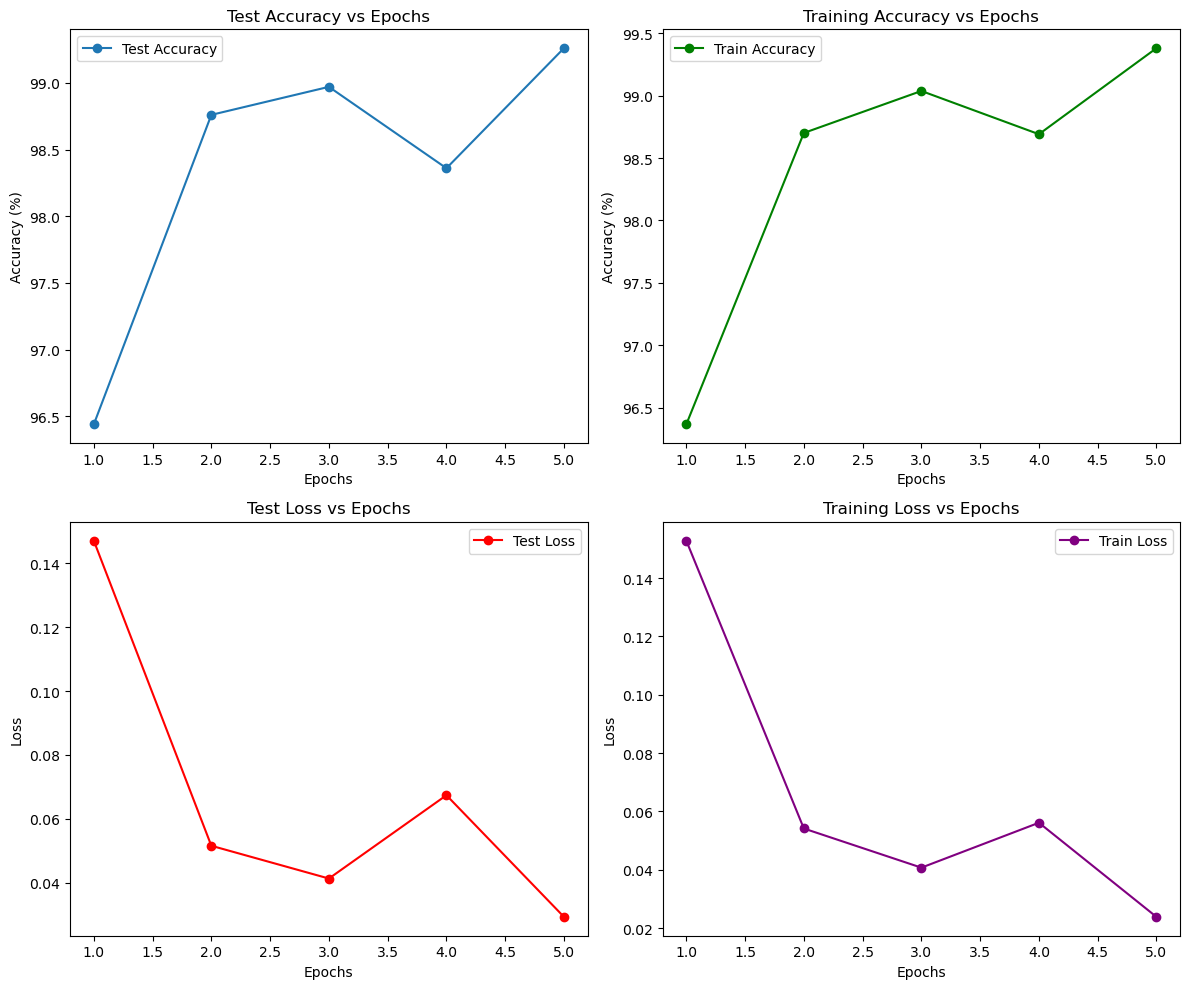

In [21]:
# Plot Accuracies and Losses
import matplotlib.pyplot as plt
num_epochs = 5

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# (a) Test accuracy vs epochs
axes[0, 0].plot(range(1, num_epochs+1), test_accuracies, marker='o', label="Test Accuracy")
axes[0, 0].set_title("Test Accuracy vs Epochs")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy (%)")
axes[0, 0].legend()

# (b) Training accuracy vs epochs
axes[0, 1].plot(range(1, num_epochs+1), train_accuracies, marker='o', color="green", label="Train Accuracy")
axes[0, 1].set_title("Training Accuracy vs Epochs")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Accuracy (%)")
axes[0, 1].legend()

# (c) Test loss vs epochs
axes[1, 0].plot(range(1, num_epochs+1), test_losses, marker='o', color="red", label="Test Loss")
axes[1, 0].set_title("Test Loss vs Epochs")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend()

# (d) Training loss vs epochs
axes[1, 1].plot(range(1, num_epochs+1), train_losses, marker='o', color="purple", label="Train Loss")
axes[1, 1].set_title("Training Loss vs Epochs")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [23]:
horizontal_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    torchvision.transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])
vertical_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    torchvision.transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

test_flip_horizontal = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=False,
    transform=horizontal_transform
)

test_flip_vertical = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=False,
    transform=vertical_transform
)

test_loader_horizontal = torch.utils.data.DataLoader(test_flip_horizontal, batch_size=64, shuffle=False)
test_loader_vertical = torch.utils.data.DataLoader(test_flip_vertical, batch_size=64, shuffle=False)

# Compute accuracy on flipped datasets
acc_original = evaluate_model(net, test_loader)
acc_hflip = evaluate_model(net, test_loader_horizontal)
acc_vflip = evaluate_model(net, test_loader_vertical)

print(f"Original Test Accuracy: {acc_original:.2f}%")
print(f"Horizontal Flip Test Accuracy: {acc_hflip:.2f}%")
print(f"Vertical Flip Test Accuracy: {acc_vflip:.2f}%")

Original Test Accuracy: 99.26%
Horizontal Flip Test Accuracy: 38.53%
Vertical Flip Test Accuracy: 40.86%


In [24]:
noise_transform_1 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x))
])
noise_transform_2 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x))
])
noise_transform_3 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x : x + 1*torch.randn_like(x))
])

test_noise_1 = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=False,
    transform=noise_transform_1
)

test_noise_2 = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=False,
    transform= noise_transform_2
)

test_noise_3 = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=False,
    transform= noise_transform_3
)

test_loader_noise_1 = torch.utils.data.DataLoader(test_noise_1, batch_size=64, shuffle=False)
test_loader_noise_2 = torch.utils.data.DataLoader(test_noise_2, batch_size=64, shuffle=False)
test_loader_noise_3 = torch.utils.data.DataLoader(test_noise_3, batch_size=64, shuffle=False)

# Compute accuracy on noise added datasets
acc_noise_1 = evaluate_model(net, test_loader_noise_1)
acc_noise_2 = evaluate_model(net, test_loader_noise_2)
acc_noise_3 = evaluate_model(net, test_loader_noise_3)

print(f"Original Test Accuracy: {acc_original:.2f}%")
print(f"Noise 0.01 Test Accuracy: {acc_noise_1:.2f}%")
print(f"Noise 0.1 Test Accuracy: {acc_noise_2:.2f}%")
print(f"Noise 1 Test Accuracy: {acc_noise_3:.2f}%")

Original Test Accuracy: 99.26%
Noise 0.01 Test Accuracy: 99.02%
Noise 0.1 Test Accuracy: 91.40%
Noise 1 Test Accuracy: 27.23%


In [29]:
augmentation_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x : x + 1*torch.randn_like(x) if torch.bernoulli(torch.tensor(0.33)) else x)
])

full_train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=augmentation_transform)
train_loader_aug = torch.utils.data.DataLoader(full_train_dataset, batch_size=64, shuffle=True)
new_net = Net()
# train the new model, outputs are irrelevant
_, _, _, _ = train_model(new_net, train_loader_aug, test_loader)

acc_hflip_aug = evaluate_model(new_net, test_loader_horizontal)
acc_vflip_aug = evaluate_model(new_net, test_loader_vertical)
print(f"Horizontal Flip Test Accuracy After Regularization: {acc_hflip_aug:.2f}%")
print(f"Vertical Flip Test Accuracy After Regularization: {acc_vflip_aug:.2f}%")

acc_noise_1_aug = evaluate_model(new_net, test_loader_noise_1)
acc_noise_2_aug = evaluate_model(new_net, test_loader_noise_2)
acc_noise_3_aug = evaluate_model(new_net, test_loader_noise_3)
print(f"Noise 0.01 Test Accuracy After Regularization: {acc_noise_1_aug:.2f}%")
print(f"Noise 0.1 Test Accuracy After Regularization: {acc_noise_2_aug:.2f}%")
print(f"Noise 1 Test Accuracy After Regularization: {acc_noise_3_aug:.2f}%")

Epoch [1/5] - Train Loss: 0.5038, Train Acc: 83.67%, Test Loss: 0.2766, Test Acc: 91.37%
Epoch [2/5] - Train Loss: 0.3630, Train Acc: 88.46%, Test Loss: 0.2247, Test Acc: 92.92%
Epoch [3/5] - Train Loss: 0.3190, Train Acc: 89.73%, Test Loss: 0.1220, Test Acc: 96.04%
Epoch [4/5] - Train Loss: 0.3029, Train Acc: 90.33%, Test Loss: 0.1158, Test Acc: 96.26%
Epoch [5/5] - Train Loss: 0.2900, Train Acc: 90.57%, Test Loss: 0.1042, Test Acc: 96.53%
Training complete.
Horizontal Flip Test Accuracy After Regularization: 96.36%
Vertical Flip Test Accuracy After Regularization: 96.79%
Noise 0.01 Test Accuracy After Regularization: 96.46%
Noise 0.1 Test Accuracy After Regularization: 95.29%
Noise 1 Test Accuracy After Regularization: 76.30%
